<a href="https://colab.research.google.com/github/jerrymart/Machine-Learning-Projects/blob/main/Time%20Series%20MA_AR_ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import The Library 

pandas: Used for data manipulation and analysis

numpy : Numpy is the core library for scientific computing in Python. 
It is used for working with arrays and matrices.

matplotlib : It’s plotting library, and we are going to use it for data visualization
seaborn: It’s a Python data visualization library based on matplotlib. 
It provides a high-level interface for drawing attractive and informative statistical graphics

statsmodels: Using statsmodels module classes and functions for time series analysis and forecasting

adfuller: Augmented Dickey-Fuller

ACF: Auto Correlation Function

PACF: Partial Auto Correlation Function

ARIMA: Autoregressive Integrated Moving Average ARIMA(p,d,q) Model

sm.tsa.seasonal.seasonal_decompose: For decomposition of time series

rcParams: To change the matplotlib properties like figure size

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [ ]:
# Set plot size 
rcParams['figure.figsize'] = 10, 6

## Load The Dataset

In [ ]:
df = pd.read_csv('/content/AirPassengers.csv', index_col=0, parse_dates=True)

In [ ]:
#Check data head
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
#Check for missing data
df.isnull().sum()

#Passengers    0
dtype: int64

In [ ]:
#Check number of rows and columns in data
print('Dataframe Shape= ', df.shape, end='\n\n')

Dataframe Shape=  (144, 1)



## Understanding The Data 

Dataframe 'df' contains the time series data. 
The X Axis is Month and Y-Axis is #passengers 

To make plotting easier, we set the index of pandas dataframe 'df' to the 'Date' column so that it will act as index

## Explore The Time Series Characteristics

####Let us check for Trend In The Data By Plotting

Text(0, 0.5, 'No of Air Passengers')

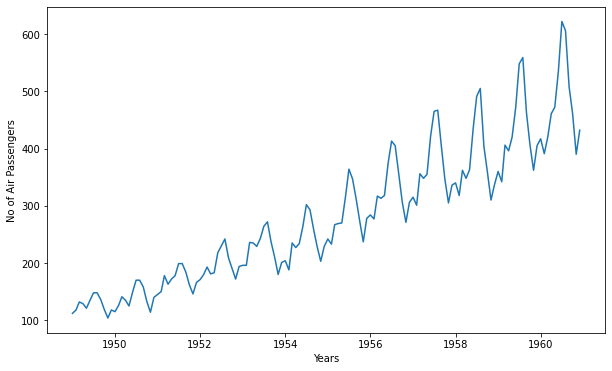

In [ ]:
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')


#### Trend
We could see a significant upward trend inn number of passengers every year

#### Variance
We could observe that the variation is also increasing with the level of the series. We will use the variance to increase the stationarity of the series in this project


####Seasonality
The plot goes up and down at regular interval, indicating significant seasonality. 

Let's plot the graph for few months to visualize for seasonality.

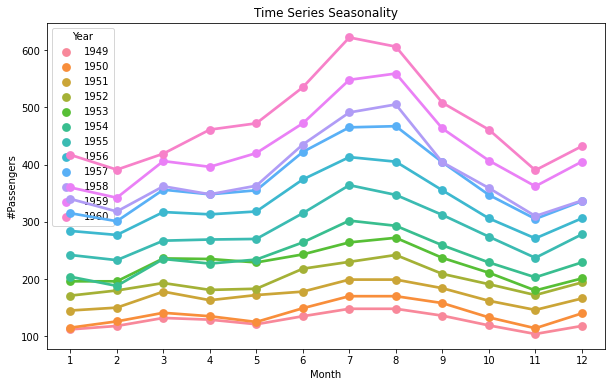

In [ ]:
# To plot the seasonality we are going to create a temp dataframe and add columns for Month and Year values
df_tp = df.copy()
df_tp['Year'] = pd.DatetimeIndex(df_tp.index).year
df_tp['Month'] = pd.DatetimeIndex(df_tp.index).month

# Stacked line plot
plt.title('Time Series Seasonality')
sns.pointplot(x='Month',y='#Passengers',hue='Year',data=df_tp)

It is seen that month of July every year there is maximum number of passengers

Also minimum #passenger in the month of November.

#### Decomposition The Time Series

Let us decompose the time series into it's trend and seasonality for more visualization investigations

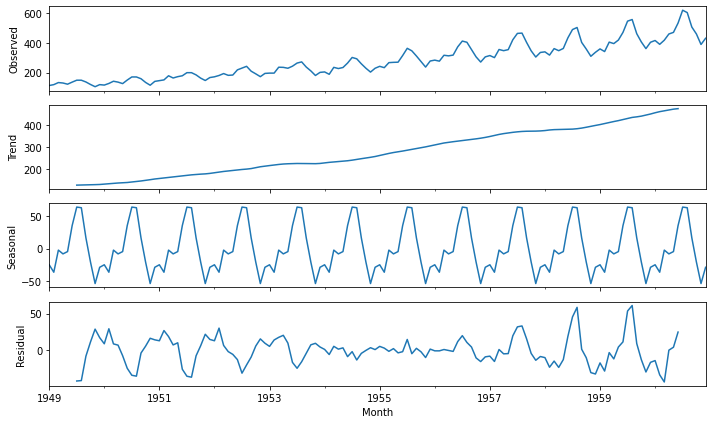

In [ ]:
decompose = sm.tsa.seasonal_decompose(df, model='additive') 
fig = decompose.plot()

#### Time Series Analysis 

Since our time series has variance, trend and seasonality as seen in the decompose object

We will try to make the time series sationary

####Check for Stationarity
We are going to use rolling statistics and Dickey-Fuller test to check the stationarity of the time series

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [ ]:
# Lets test the stationarity score with original series data
adf_test(df['#Passengers'])

1. ADF :  0.8153688792060418
2. P-Value :  0.9918802434376409
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598


Duckey Fuller Test: Test statistic is way more than the critical values.

Hence The data is not stationary because P-Value > 0.05

We will need to carry out differencing until time series is stationary only then we can model with MA, AR, ARIMA etal

####Differencing
We will use differencing to make the time series stationary

We will use the diff() method of pandas. 

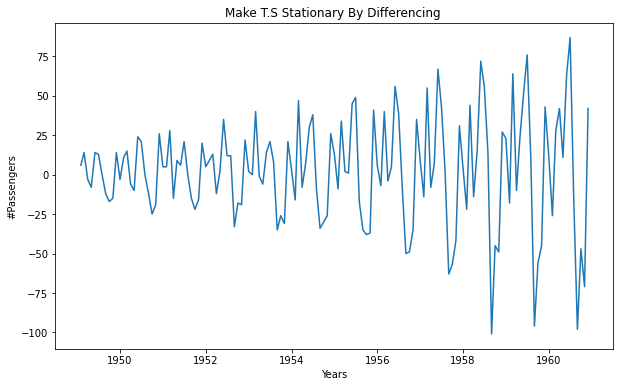

In [ ]:
df_diff = df.diff(periods = 1) # 1 indicate First order differencing

#plot the difference time series
plt.xlabel('Years')
plt.ylabel('#Passengers')    
plt.title('Make T.S Stationary By Differencing ')
plt.plot(df_diff)

We can see differencing removed the trend from the time series, but variance is still there 

Now lets run the stationarity check to observe the effectiveness of the Differencing if the data is stationary 

or maybe we need to carry out second order differencing

In [ ]:
df_diff.dropna(inplace = True)# Data transformation may add na values

adf_test(df_diff['#Passengers'])

1. ADF :  -2.8292668241699976
2. P-Value :  0.054213290283825745
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598


The time series is still not stationary

The variance in the series is also affecting above results, 
we will removed using transformation technique.


#### Remove the variance suning Transformation
Since variance is proportional to the levels, we are going to use the log transformation.

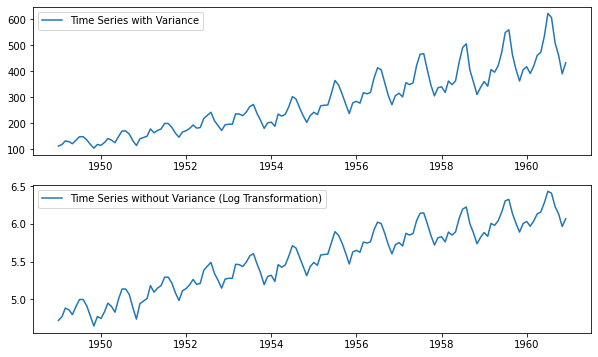

In [ ]:
df_log = np.log(df) # take the log of the time series

plt.subplot(211)
plt.plot(df, label= 'Time Series with Variance')
plt.legend()

plt.subplot(212)
plt.plot(df_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()

The variance has been removed as seen in 'Time Series without Variance (Log Transformation)'

We will be working with transformed data. 

We can use the exponential of the series to get the original scale back if need be.

df = exp(df_log)

## Let cross-check the differencing method scores with this log transformed data again.

In [ ]:
df_log_diff = df_log.diff(periods = 1) # First order differencing

df_log_diff.dropna(inplace = True)# Data transformation may add na values
#adf_test(df['#Passengers'])
adf_test(df_log_diff['#Passengers'])

1. ADF :  -2.7171305983881044
2. P-Value :  0.07112054815086355
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 128
5. Critical Values :
	 1% :  -3.4825006939887997
	 5% :  -2.884397984161377
	 10% :  -2.578960197753906


p-value is greater than 0.05 it is not a stationary series.

This is a sturbon time series lol !!!

Let's also check with Moving Average technique…

####Moving Average
Since we have time series data from 1 Jan 1949 to 1 Dec 1960, 

we will define a yearly window for moving average. Window size = 12. 

We are going to use Log transformed data.

In [ ]:
df_log_moving_avg = df_log.rolling(window = 12).mean()

df_log_moving_avg_diff = df_log - df_log_moving_avg

df_log_moving_avg_diff.dropna(inplace = True)

adf_test(df_log_moving_avg_diff['#Passengers'])

1. ADF :  -3.16290799130085
2. P-Value :  0.022234630001244364
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 119
5. Critical Values :
	 1% :  -3.4865346059036564
	 5% :  -2.8861509858476264
	 10% :  -2.579896092790057


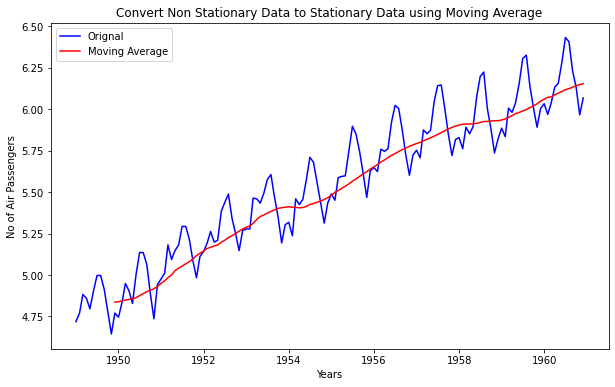

In [ ]:
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Moving Average')
plt.plot(df_log, color= 'blue', label='Orignal')
plt.plot(df_log_moving_avg, color= 'red', label='Moving Average')
plt.legend()

P-value is less than 0.05 that means our series is stationary

Let us improve the stationarity of the time series using 'Weighted Moving Average' technique

###Weighted Moving Average (WMA)

Let us use exponentially weighted moving average with parameter ‘halflife = 12’. 

This parameter defines the amount of exponential decay.

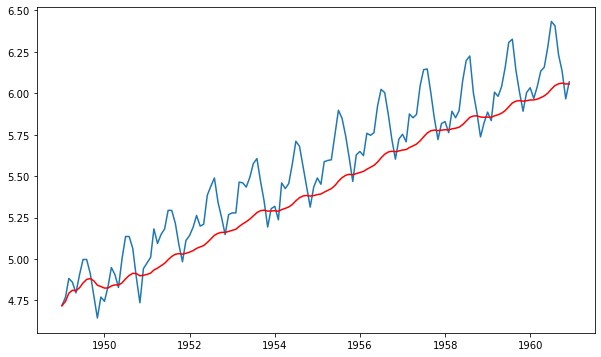

In [ ]:
df_log_weighted_avg = df_log.ewm(halflife = 12).mean()
plt.plot(df_log)
plt.plot(df_log_weighted_avg, color = 'red')

WMA follow's no of passenger values more closely than a corresponding Simple Moving Average which also results in more accurate trend direction. 

Now lets check, the effect of this on stationarity scores!

In [ ]:
df_log_weighted_avg_diff = df_log - df_log_weighted_avg
adf_test(df_log_weighted_avg_diff['#Passengers'])

1. ADF :  -3.601262420161687
2. P-Value :  0.005736938801511691
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598


We now have a better stationary time series to work with

Next we will make forcast

# Forecasting

We are going to use ARIMA for forecast.

Then we break it into the AR Modelling and MA Modelling

To use this technique, we need to determing the p and q values of the ARIMA so we can extract MA(q) and AR(p) out and model them individually

This can be achieved using the ACF and PACF plots 

###ACF and PACF Plots for AR(p) and MA(q)
To get the AR orde we use PACF function.
p = no of lags where PACF chart crosses the upper confidence interval for the first time


To figure out the order of MA model(q) we will use ACF function.
q = the lag value where the ACF chart crosses the upper confidence interval for the first time

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


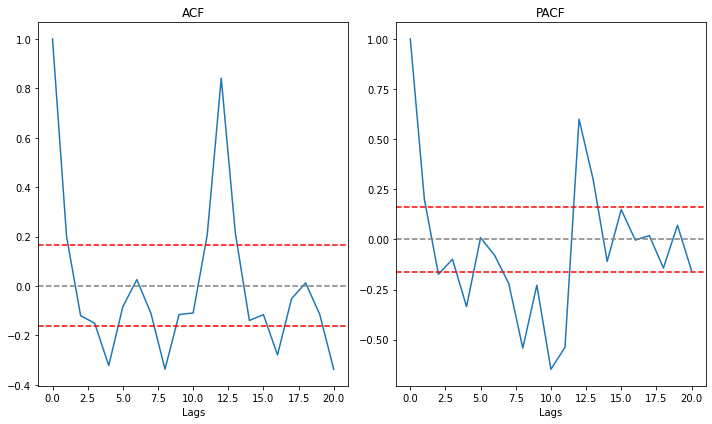

In [ ]:
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')

# Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')

# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('ACF')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf,)
plt.axhline(y=0,linestyle='--',color='gray')

# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('PACF')
plt.tight_layout()

We can see from PACF and ACF plot plot that p=2 and q=2. 

#Modelling

Let us  make 3 different ARIMA models considering individual as well as combined effects. 

We will also print the RSS(Residual Sum of Square) metric for each. to account for permformance 

#MA Model Model 1

Since 'p' is AR model parameter we will keep its value as '0'.

Text(0.5, 1.0, 'MA Model, RSS: 1.4721')

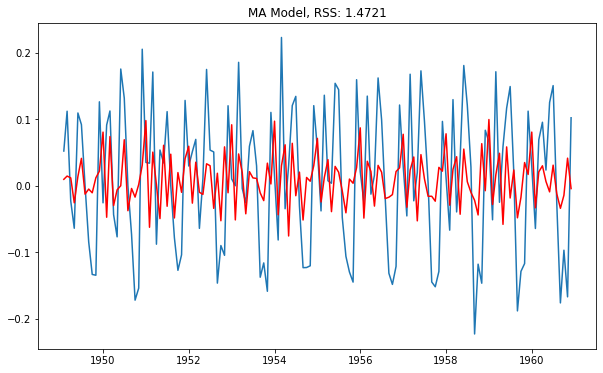

In [ ]:
model = ARIMA(df_log, order=(0, 1, 2), freq = 'MS')  
results_MA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model, RSS: %.4f'% sum((results_MA.fittedvalues-df_log_diff['#Passengers'])**2))

We can see that the MA Model, RSS: 1.4721

#AR Model Model 2
Since 'q' is MA model parameter we will keep its value as '0'.

Text(0.5, 1.0, 'AR Model, RSS: 1.5023')

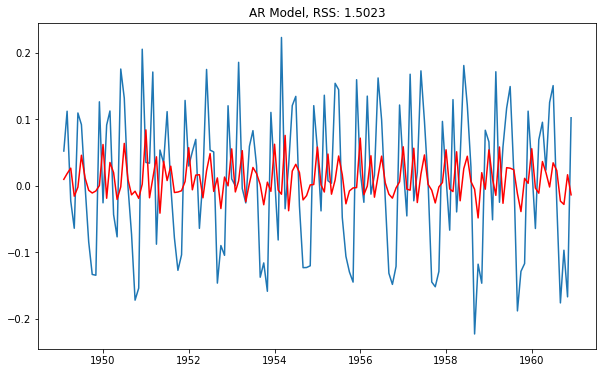

In [ ]:
model = ARIMA(df_log, order=(2, 1, 0), freq = 'MS')  
results_AR = model.fit(disp= -1)# If disp < 0 convergence information will not be printed

plt.plot(df_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR Model, RSS: %.4f'% sum((results_AR.fittedvalues - df_log_diff['#Passengers'])**2))

AR Model, RSS: 1.5023

#ARIMA Model 3

Text(0.5, 1.0, 'ARIMA Model, RSS: 1.0292')

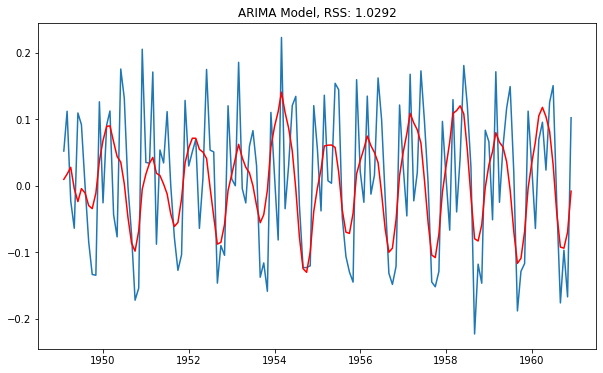

In [ ]:
model = ARIMA(df_log, order=(2, 1, 2), freq = 'MS')  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA Model, RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_log_diff['#Passengers'])**2))

ARIMA Model, RSS: 1.0292

AR and MA models have almost the same RSS score 

ARIMA is much better. So we will go ahead with  ARIMA model and use it for predictions.

###Prediction and Reverse Transformation
We will create a separate series of predicted values using ARIMA model

Reverse transform the predicted values to get the original scale back

Compare the predicted values with original values and plot them

In [ ]:
# Create a separate series of predicted values
predictions_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

print('Total no of predictions: ', len(predictions_diff))
predictions_diff.head()

Total no of predictions:  143


Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

Since we are using first order of differencing(d =1), there is no prediction available for first value (1949-02-01) of original series. In order to remove 'differencing transformation' from the prediction values we are going to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. We are going to use pandas cumsum() function for it.

In [ ]:
predictions_diff_cumsum = predictions_diff.cumsum()
predictions_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

Above values once added to the base number will completely remove the differencing transformation. For this, lets create a series with all values as base number and add the 'predictions_diff_cumsum' to it

In [ ]:
predictions_log = pd.Series(df_log['#Passengers'].iloc[0], index=df_log.index) # Series of base number
predictions_log = predictions_log.add(predictions_diff_cumsum,fill_value=0)
predictions_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

#Making Predictions

So as of now we have removed the differencing transformation, now lets remove the log transformation to get the original scale back.

In [ ]:
predictions = np.exp(predictions_log)
df_predictions =pd.DataFrame(predictions, columns=['Predicted Values'])
pd.concat([df,df_predictions],axis =1).T

Month,1949-01-01,1949-02-01,1949-03-01,1949-04-01,1949-05-01,1949-06-01,1949-07-01,1949-08-01,1949-09-01,1949-10-01,1949-11-01,1949-12-01,1950-01-01,1950-02-01,1950-03-01,1950-04-01,1950-05-01,1950-06-01,1950-07-01,1950-08-01,1950-09-01,1950-10-01,1950-11-01,1950-12-01,1951-01-01,1951-02-01,1951-03-01,1951-04-01,1951-05-01,1951-06-01,1951-07-01,1951-08-01,1951-09-01,1951-10-01,1951-11-01,1951-12-01,1952-01-01,1952-02-01,1952-03-01,1952-04-01,...,1957-09-01,1957-10-01,1957-11-01,1957-12-01,1958-01-01,1958-02-01,1958-03-01,1958-04-01,1958-05-01,1958-06-01,1958-07-01,1958-08-01,1958-09-01,1958-10-01,1958-11-01,1958-12-01,1959-01-01,1959-02-01,1959-03-01,1959-04-01,1959-05-01,1959-06-01,1959-07-01,1959-08-01,1959-09-01,1959-10-01,1959-11-01,1959-12-01,1960-01-01,1960-02-01,1960-03-01,1960-04-01,1960-05-01,1960-06-01,1960-07-01,1960-08-01,1960-09-01,1960-10-01,1960-11-01,1960-12-01
#Passengers,112.0,118.000000,132.000000,129.000000,121.00000,135.000000,148.000000,148.000000,136.000000,119.000000,104.000000,118.00000,115.00000,126.000000,141.000000,135.000000,125.000000,149.000000,170.000000,170.000000,158.000000,133.000000,114.000000,140.000000,145.000000,150.000000,178.000000,163.000000,172.000000,178.000000,199.000000,199.000000,184.000000,162.00000,146.000000,166.000000,171.000000,180.000000,193.00000,181.000000,...,404.000000,347.000000,305.000000,336.000000,340.000000,318.000000,362.000000,348.00000,363.000000,435.000000,491.000000,505.000000,404.000000,359.000000,310.000000,337.000000,360.000000,342.0000,406.000000,396.000000,420.000000,472.00000,548.000000,559.0000,463.000000,407.000000,362.000000,405.000000,417.000000,391.000000,419.000000,461.000000,472.000000,535.000000,622.000000,606.000000,508.000000,461.000000,390.000000,432.000000
Predicted Values,112.0,113.078122,115.073416,118.301992,117.76837,114.988278,114.489526,113.239584,109.900662,106.177219,104.986418,108.96678,116.64999,127.563198,139.580454,149.126199,155.842565,161.469042,161.970404,154.514246,141.731371,128.440839,120.015654,119.389909,121.483628,125.687055,131.151928,133.633911,135.688791,136.026969,134.349575,128.760397,121.101054,114.58161,112.360996,116.311552,123.130859,132.261596,142.04913,150.041841,...,238.887376,214.392091,199.323749,197.414296,203.290509,217.069251,242.024239,271.00733,305.639666,340.555468,359.622488,353.749602,326.603791,300.547169,283.364842,282.611382,291.567541,306.9598,332.461236,354.907619,376.172316,389.99027,387.398988,361.5625,321.685209,288.377209,269.078794,268.100227,277.433136,296.364648,329.212535,370.428488,411.049868,446.085237,460.460805,441.885939,402.905455,366.753069,341.984372,339.216341


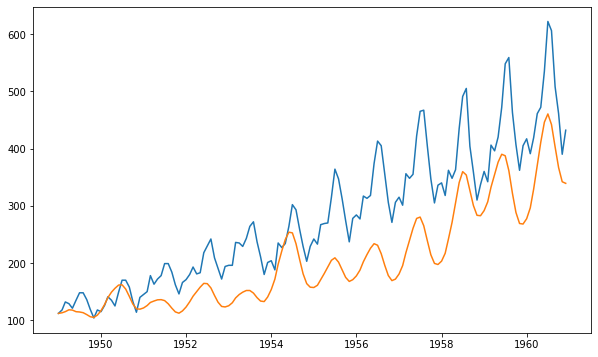

In [ ]:
#Prediction Plot
plt.plot(df)
plt.plot(predictions)

#Future Forecasting
We have data from 1 Jan 1949 to 1 Dec 1960. 12 years of data with passenger number observation for each month i.e. 144 total observations.
If we want to forecast for next 5 years or 60 months then, ‘end’ count will be > 144 + 60 = 204.
We are going to use statsmodels plot_predict() method for it

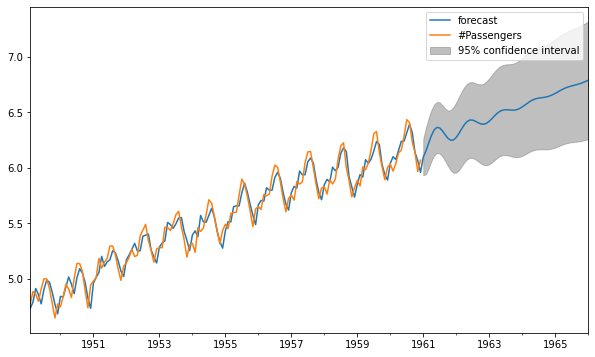

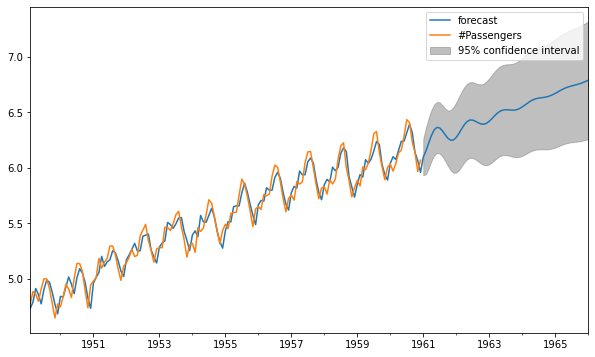

In [ ]:
results_ARIMA.plot_predict(start = 1, end= 204)

In [ ]:
# Forecasted values in original scale will be
forecast_values_log_scale = results_ARIMA.forecast(steps = 60)
forecast_values_original_scale = np.exp(forecast_values_log_scale[0])

forecast_date_range= pd.date_range("1961-01-01", "1965-12-01", freq="MS")

df_forecast =pd.DataFrame(forecast_values_original_scale, columns=['Forecast'])
df_forecast['Month'] = forecast_date_range

df_forecast[['Month', 'Forecast']]

,Month,Forecast
0,1961-01-01,443.870937
1,1961-02-01,470.038159
2,1961-03-01,504.934889
3,1961-04-01,540.454725
4,1961-05-01,567.730639
5,1961-06-01,580.328084
6,1961-07-01,577.002679
7,1961-08-01,561.938901
8,1961-09-01,542.384673
9,1961-10-01,525.566732


#Performance Of Models

ARIMA shows the best performance comparing all the RSS values, hence it was used for preiction and future forcasting